# Libraries

---



In [1]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00


In [99]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import auc
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as ticker

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statistics as stat
import scipy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from datetime import time
import holidays

import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

Note : GitHub tidak dapat menampilkan Plotly

# Membaca Data


---



In [2]:
prefix = 'Case Study - '
customer = pd.read_csv(prefix + 'Customer.csv', sep = ';')
product = pd.read_csv(prefix + 'Product.csv', sep = ';')
store = pd.read_csv(prefix + 'Store.csv', sep = ';')
transaction = pd.read_csv(prefix + 'Transaction.csv', sep = ';')

In [3]:
transaction.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4

In [4]:
customer.head()

CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57

In [5]:
product

ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200
5        P6         Cashew  18000
6        P7   Coffee Candy   9400
7        P8            Oat  16000
8        P9        Yoghurt  10000
9       P10   Cheese Stick  15000

In [6]:
store

StoreID         StoreName    GroupStore           Type   Latitude  \
0         1     Prima Tendean         Prima   Modern Trade       -6,2   
1         2  Prima Kelapa Dua         Prima   Modern Trade  -6,914864   
2         3        Prima Kota         Prima   Modern Trade  -7,797068   
3         4       Gita Ginara          Gita  General Trade  -6,966667   
4         5           Bonafid          Gita  General Trade  -7,250445   
5         6            Lingga        Lingga   Modern Trade  -5,135399   
6         7       Buana Indah         Buana  General Trade   3,316694   
7         8     Sinar Harapan  Harapan Baru  General Trade    5,54829   
8         9            Lingga        Lingga   Modern Trade  -3,654703   
9        10      Harapan Baru  Harapan Baru  General Trade   3,597031   
10       11     Sinar Harapan      Prestasi  General Trade   0,533505   
11       12    Prestasi Utama      Prestasi  General Trade  -2,990934   
12       13             Buana         Buana  General Trade   -1,26916   
13       14          Priangan      Priangan   Modern Trade      -5,45   

     Longitude  
0   106,816666  
1   107,608238  
2   110,370529  
3   110,416664  
4   112,768845  
5    119,42379  
6   114,590111  
7    95,323753  
8   128,190643  
9    98,678513  
10  101,447403  
11  104,756554  
12  116,825264  
13   105,26667

In [7]:
store.at[5,'StoreName'] = 'Lingga Makassar'
store.at[8,'StoreName'] = 'Lingga Ambon'
store.at[7, 'StoreName'] = 'Sinar Harapan Aceh'
store.at[10, 'StoreName'] = 'Sinar Harapan Riau'

In [8]:
store['Latitude'] = store['Latitude'].str.replace(',', '.').astype(float)
store['Longitude'] = store['Longitude'].str.replace(',', '.').astype(float)

In [9]:
transaction['Date'] = pd.to_datetime(transaction['Date'])
transaction = pd.merge(transaction, product[['ProductID', 'Product Name']], on='ProductID')
transaction = pd.merge(transaction, store[['StoreID', 'StoreName']], on='StoreID')
transaction.drop(['ProductID', 'StoreID'],axis=1,inplace=True)
transaction

TransactionID  CustomerID       Date  Price  Qty  TotalAmount  \
0          TR11369         328 2022-01-01   7500    4        30000   
1          TR36491         117 2022-03-01   7500    4        30000   
2           TR4331         335 2022-08-01   7500    3        22500   
3           TR6445         181 2022-10-01   7500    4        30000   
4          TR75889         154 2022-01-19   7500    3        22500   
...            ...         ...        ...    ...  ...          ...   
5015       TR35686          53 2022-09-26  18000    1        18000   
5016       TR31161         251 2022-01-11  18000    1        18000   
5017       TR39496         211 2022-11-20  18000    4        72000   
5018       TR10642         203 2022-11-24  18000    3        54000   
5019       TR31635          37 2022-12-26  18000    2        36000   

     Product Name       StoreName  
0        Crackers  Prestasi Utama  
1        Crackers  Prestasi Utama  
2        Crackers  Prestasi Utama  
3        Crackers  Prestasi Utama  
4        Crackers  Prestasi Utama  
...           ...             ...  
5015       Cashew   Prima Tendean  
5016       Cashew   Prima Tendean  
5017       Cashew   Prima Tendean  
5018       Cashew   Prima Tendean  
5019       Cashew   Prima Tendean  

[5020 rows x 8 columns]

In [10]:
transaction['Hari'] = transaction['Date'].dt.day
transaction['Bulan'] = transaction['Date'].dt.month

In [11]:
transaction.head()

TransactionID  CustomerID       Date  Price  Qty  TotalAmount Product Name  \
0       TR11369         328 2022-01-01   7500    4        30000     Crackers   
1       TR36491         117 2022-03-01   7500    4        30000     Crackers   
2        TR4331         335 2022-08-01   7500    3        22500     Crackers   
3        TR6445         181 2022-10-01   7500    4        30000     Crackers   
4       TR75889         154 2022-01-19   7500    3        22500     Crackers   

        StoreName  Hari  Bulan  
0  Prestasi Utama     1      1  
1  Prestasi Utama     1      3  
2  Prestasi Utama     1      8  
3  Prestasi Utama     1     10  
4  Prestasi Utama    19      1

In [12]:
all_data = transaction.groupby(['Date'])['Qty'].sum()
all_data

Date
2022-01-01    49
2022-01-02    50
2022-01-03    76
2022-01-04    98
2022-01-05    67
              ..
2022-12-27    70
2022-12-28    68
2022-12-29    42
2022-12-30    44
2022-12-31    37
Name: Qty, Length: 365, dtype: int64

In [92]:
cluster_data = transaction.groupby('CustomerID').agg({'TransactionID':'count','Qty':'sum','TotalAmount':'sum'})

In [93]:
cluster_data

TransactionID  Qty  TotalAmount
CustomerID                                 
1                      17   60       623300
2                      13   57       392300
3                      15   56       446200
4                      10   46       302500
5                       7   27       268600
...                   ...  ...          ...
443                    16   59       485100
444                    18   62       577700
445                    18   68       587200
446                    11   42       423300
447                    13   42       439300

[447 rows x 3 columns]

# EDA


---



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Crackers'),
  Text(1, 0, 'Yoghurt'),
  Text(2, 0, 'Choco Bar'),
  Text(3, 0, 'Cheese Stick'),
  Text(4, 0, 'Oat'),
  Text(5, 0, 'Thai Tea'),
  Text(6, 0, 'Coffee Candy'),
  Text(7, 0, 'Potato Chip'),
  Text(8, 0, 'Ginger Candy '),
  Text(9, 0, 'Cashew')])

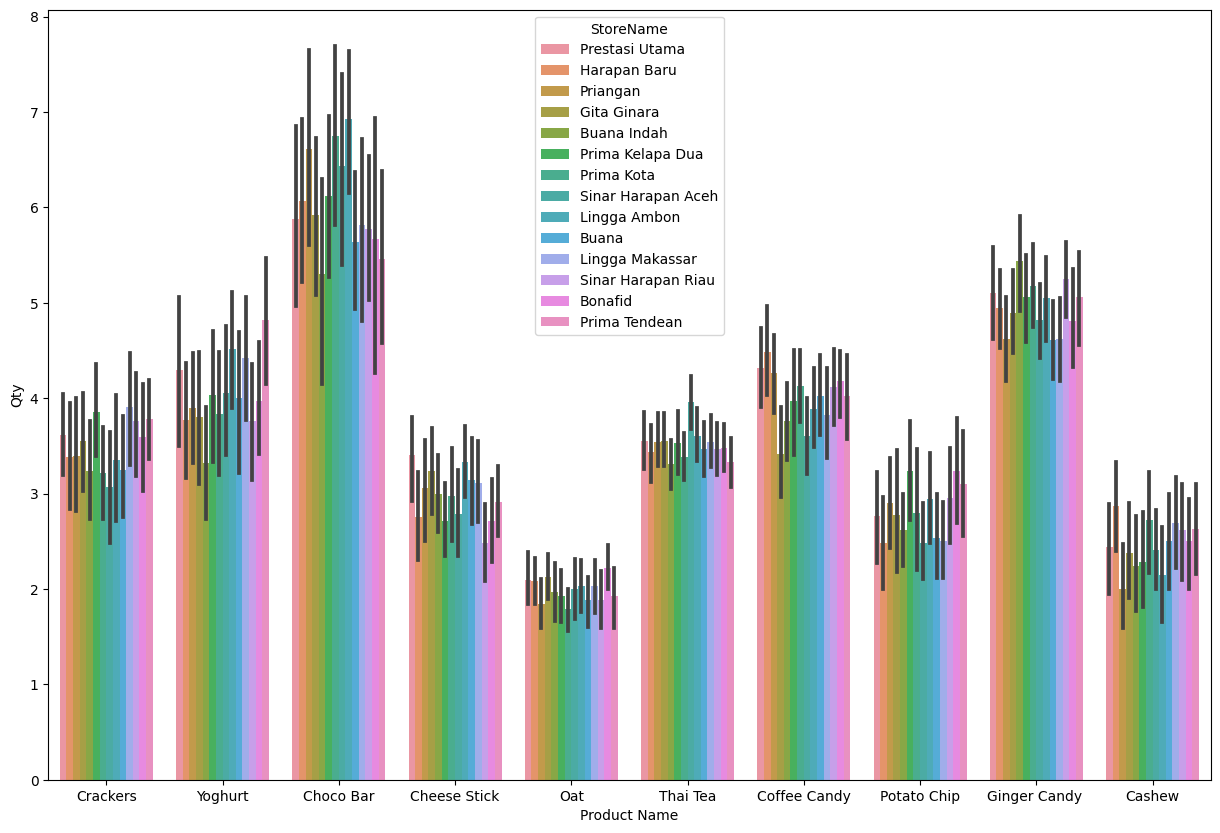

In [ ]:
plt.figure(figsize = (15, 10))

ax = sns.barplot(data = transaction, x = 'Product Name', y = 'Qty', hue = 'StoreName')
plt.xticks()

In [ ]:
df = store[['Latitude', 'Longitude', 'StoreName']]
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="StoreName",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=3.5,
                  mapbox_style="carto-positron", opacity=1)
fig.update_layout(mapbox_center=dict(lat=-1, lon=120))
fig.show()

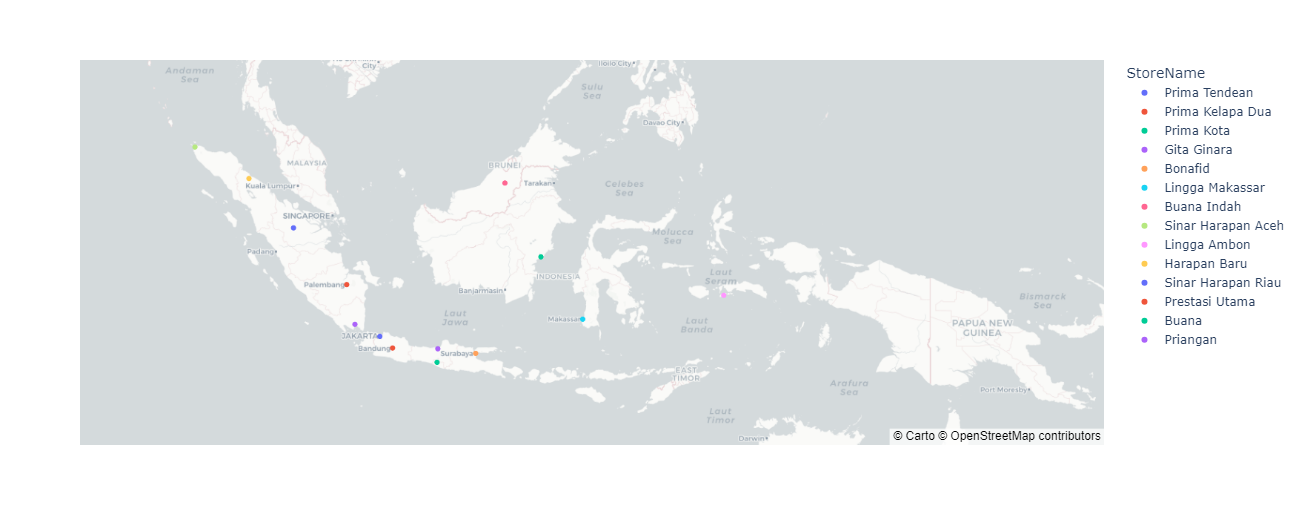

In [100]:
Image(filename='StoreName.png')

In [ ]:
df = store[['Latitude', 'Longitude', 'GroupStore']]
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="GroupStore",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=3.5,
                  mapbox_style="carto-positron", opacity=1)
fig.update_layout(mapbox_center=dict(lat=-1, lon=120))
fig.show()

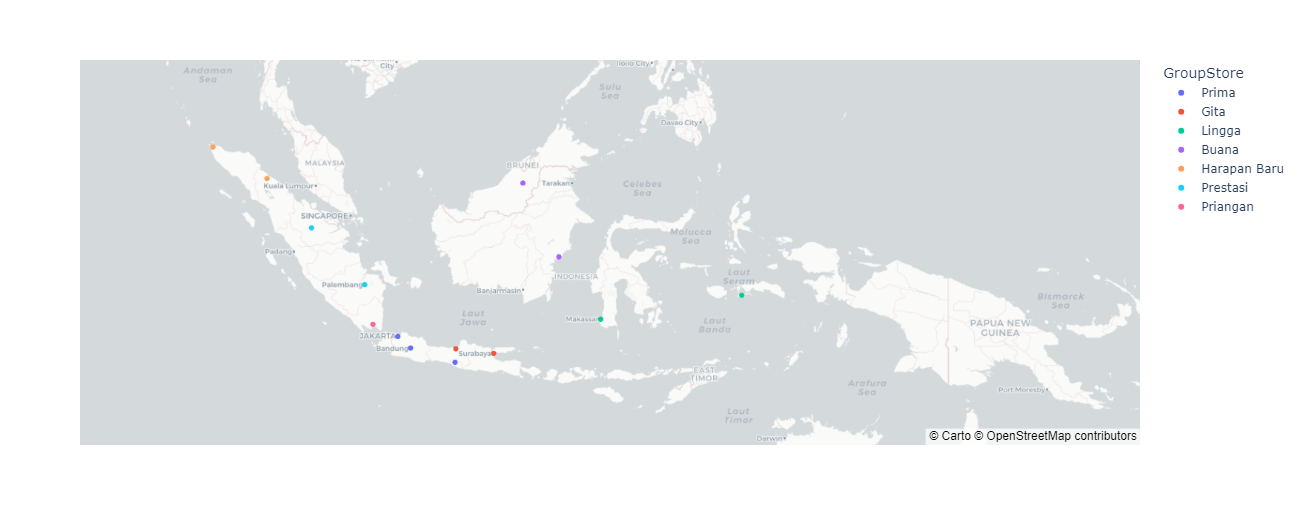

In [101]:
Image(filename='StoreGroup.png')

In [ ]:
store

StoreID           StoreName    GroupStore           Type  Latitude  \
0         1       Prima Tendean         Prima   Modern Trade -6.200000   
1         2    Prima Kelapa Dua         Prima   Modern Trade -6.914864   
2         3          Prima Kota         Prima   Modern Trade -7.797068   
3         4         Gita Ginara          Gita  General Trade -6.966667   
4         5             Bonafid          Gita  General Trade -7.250445   
5         6     Lingga Makassar        Lingga   Modern Trade -5.135399   
6         7         Buana Indah         Buana  General Trade  3.316694   
7         8  Sinar Harapan Aceh  Harapan Baru  General Trade  5.548290   
8         9        Lingga Ambon        Lingga   Modern Trade -3.654703   
9        10        Harapan Baru  Harapan Baru  General Trade  3.597031   
10       11  Sinar Harapan Riau      Prestasi  General Trade  0.533505   
11       12      Prestasi Utama      Prestasi  General Trade -2.990934   
12       13               Buana         Buana  General Trade -1.269160   
13       14            Priangan      Priangan   Modern Trade -5.450000   

     Longitude  
0   106.816666  
1   107.608238  
2   110.370529  
3   110.416664  
4   112.768845  
5   119.423790  
6   114.590111  
7    95.323753  
8   128.190643  
9    98.678513  
10  101.447403  
11  104.756554  
12  116.825264  
13  105.266670

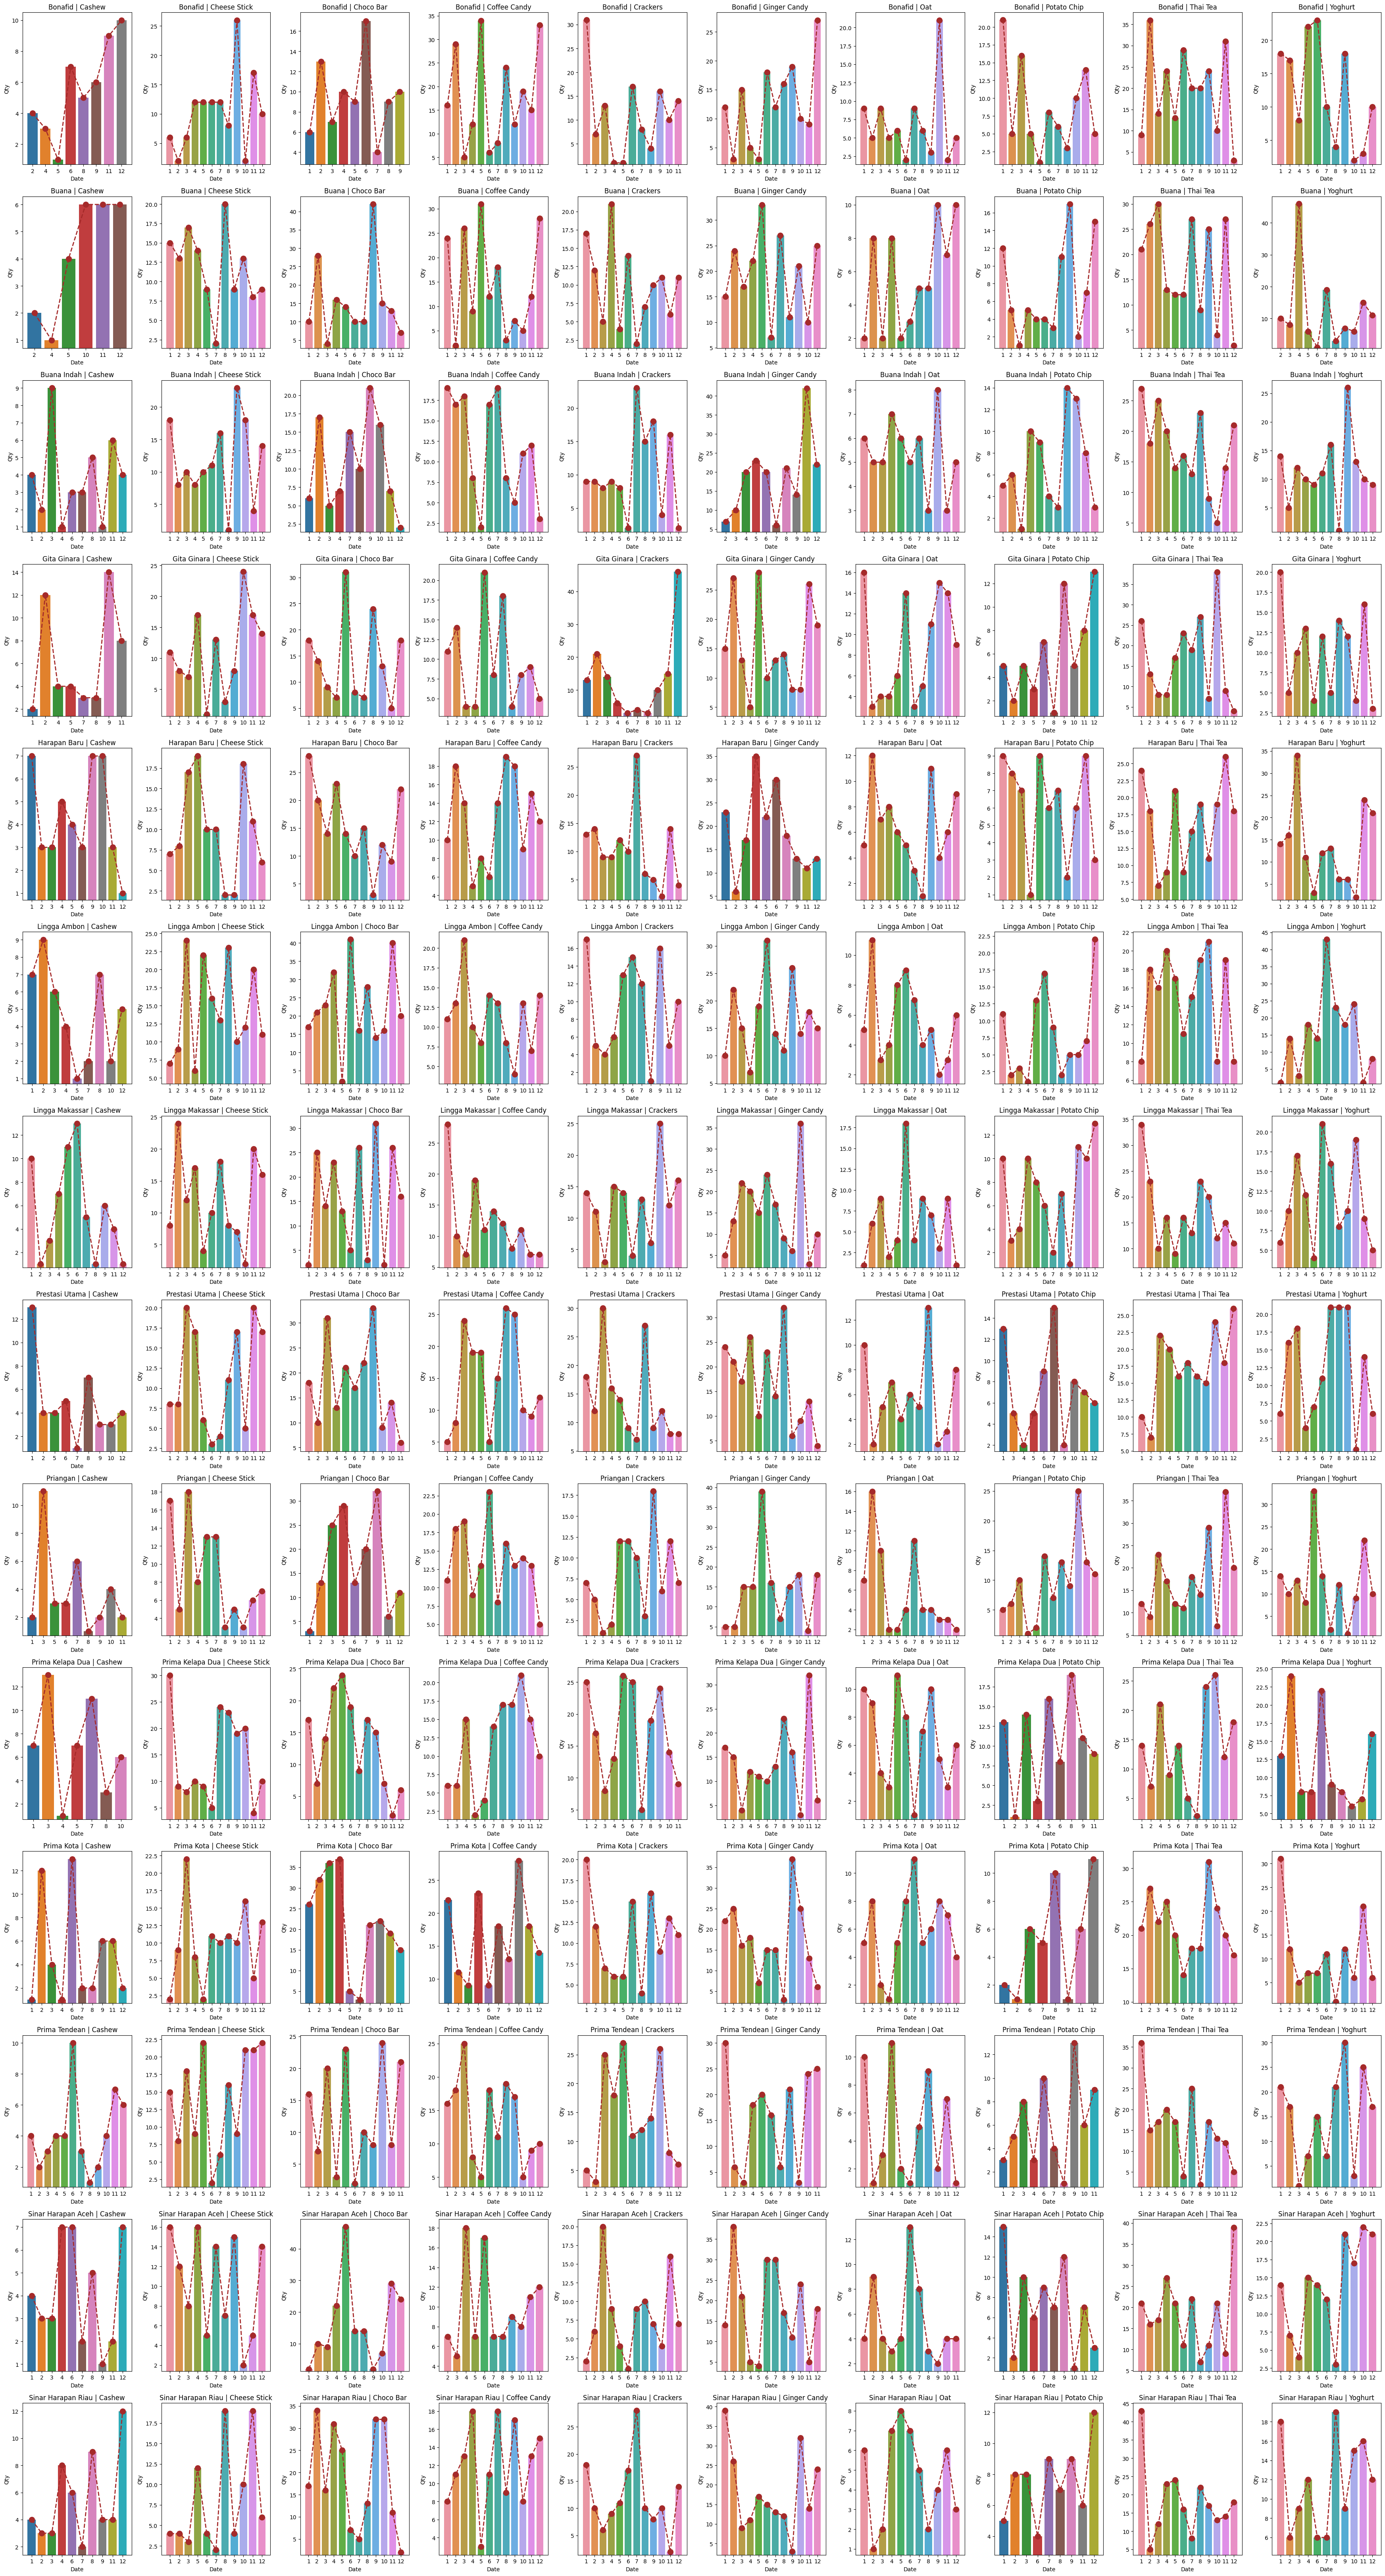

In [ ]:
fig, ax = plt.subplots(14, 10, figsize = (35, 65))
ax = ax.flatten()
for i, (combination, df) in enumerate(transaction.groupby(['StoreName', 'Product Name'])):
    data = df.groupby(df.Date.dt.month)['Qty'].sum().reset_index()
    sns.barplot(data = data, x = 'Date', y = 'Qty', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.Qty,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    lims = ax[i].get_ylim()
    ax[i].set_ylim(data.Qty.min()*0.7, lims[1])
    ax[i].set_title(combination[0] + ' | ' + combination[1])
plt.tight_layout()

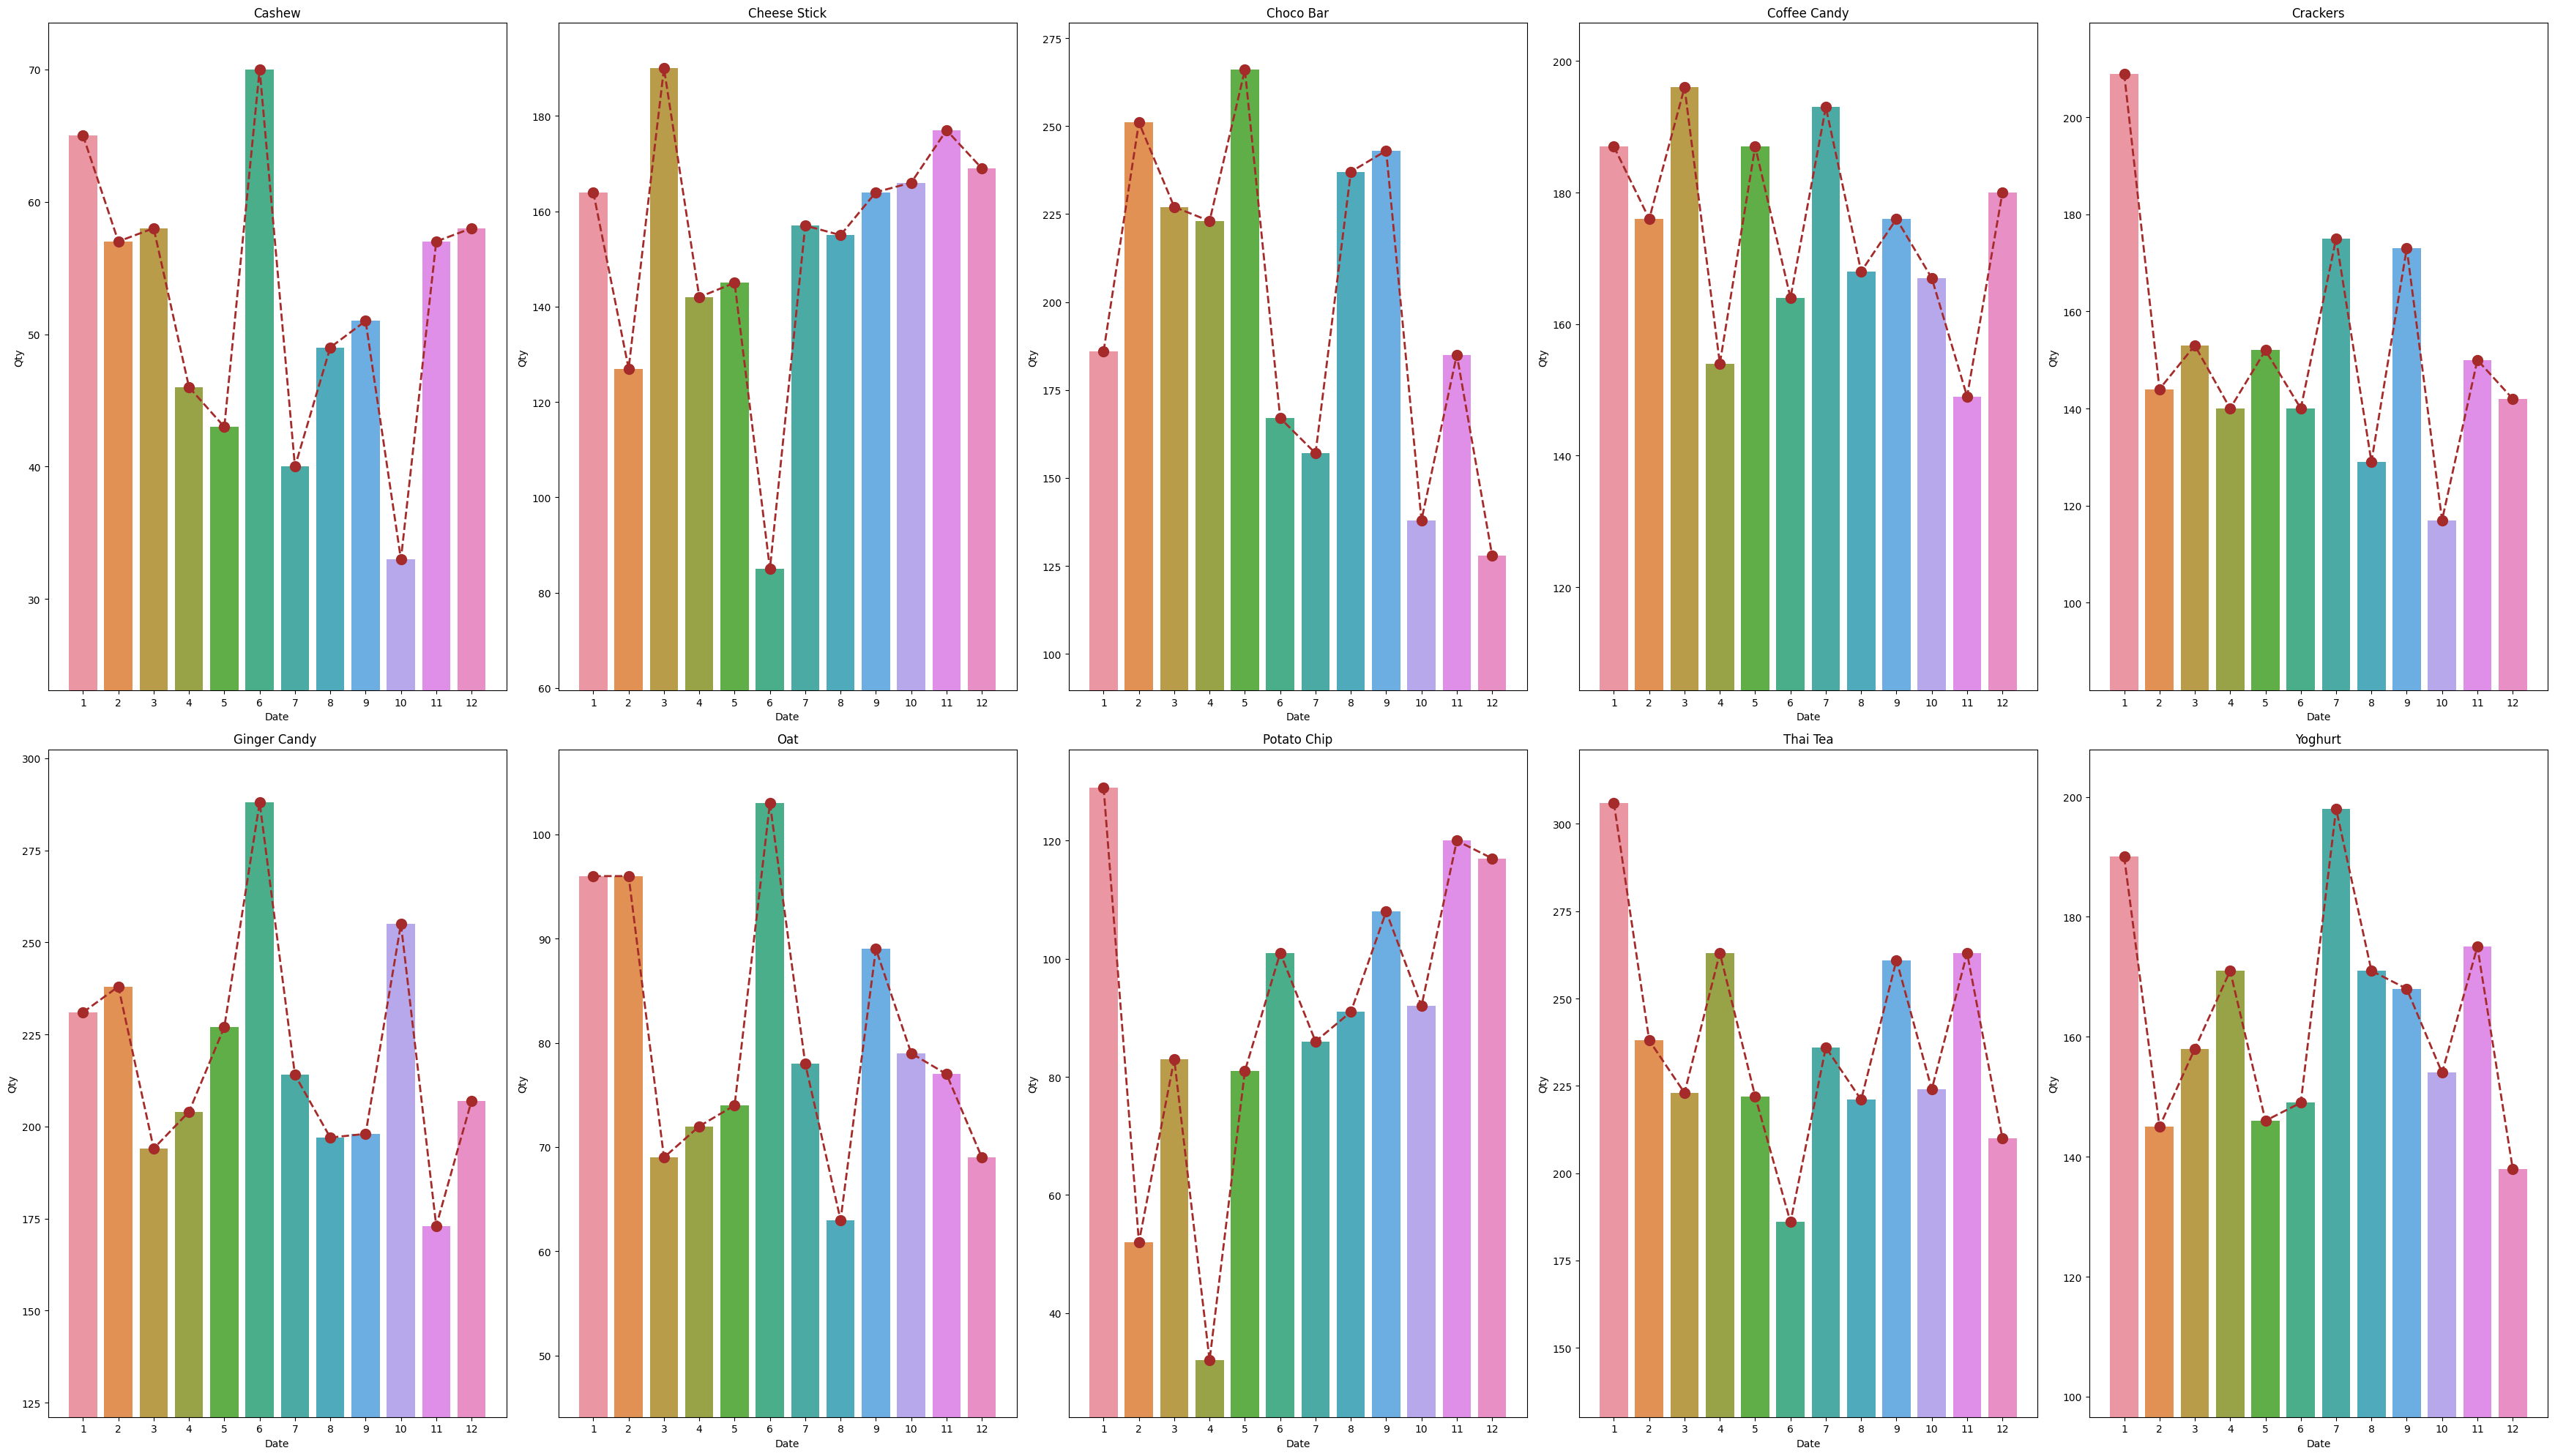

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (35, 20))
ax = ax.flatten()
for i, (combination, df) in enumerate(transaction.groupby(['Product Name'])):
    data = df.groupby(df.Date.dt.month)['Qty'].sum().reset_index()
    sns.barplot(data = data, x = 'Date', y = 'Qty', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.Qty,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    lims = ax[i].get_ylim()
    ax[i].set_ylim(data.Qty.min()*0.7, lims[1])
    ax[i].set_title(combination)
plt.tight_layout()

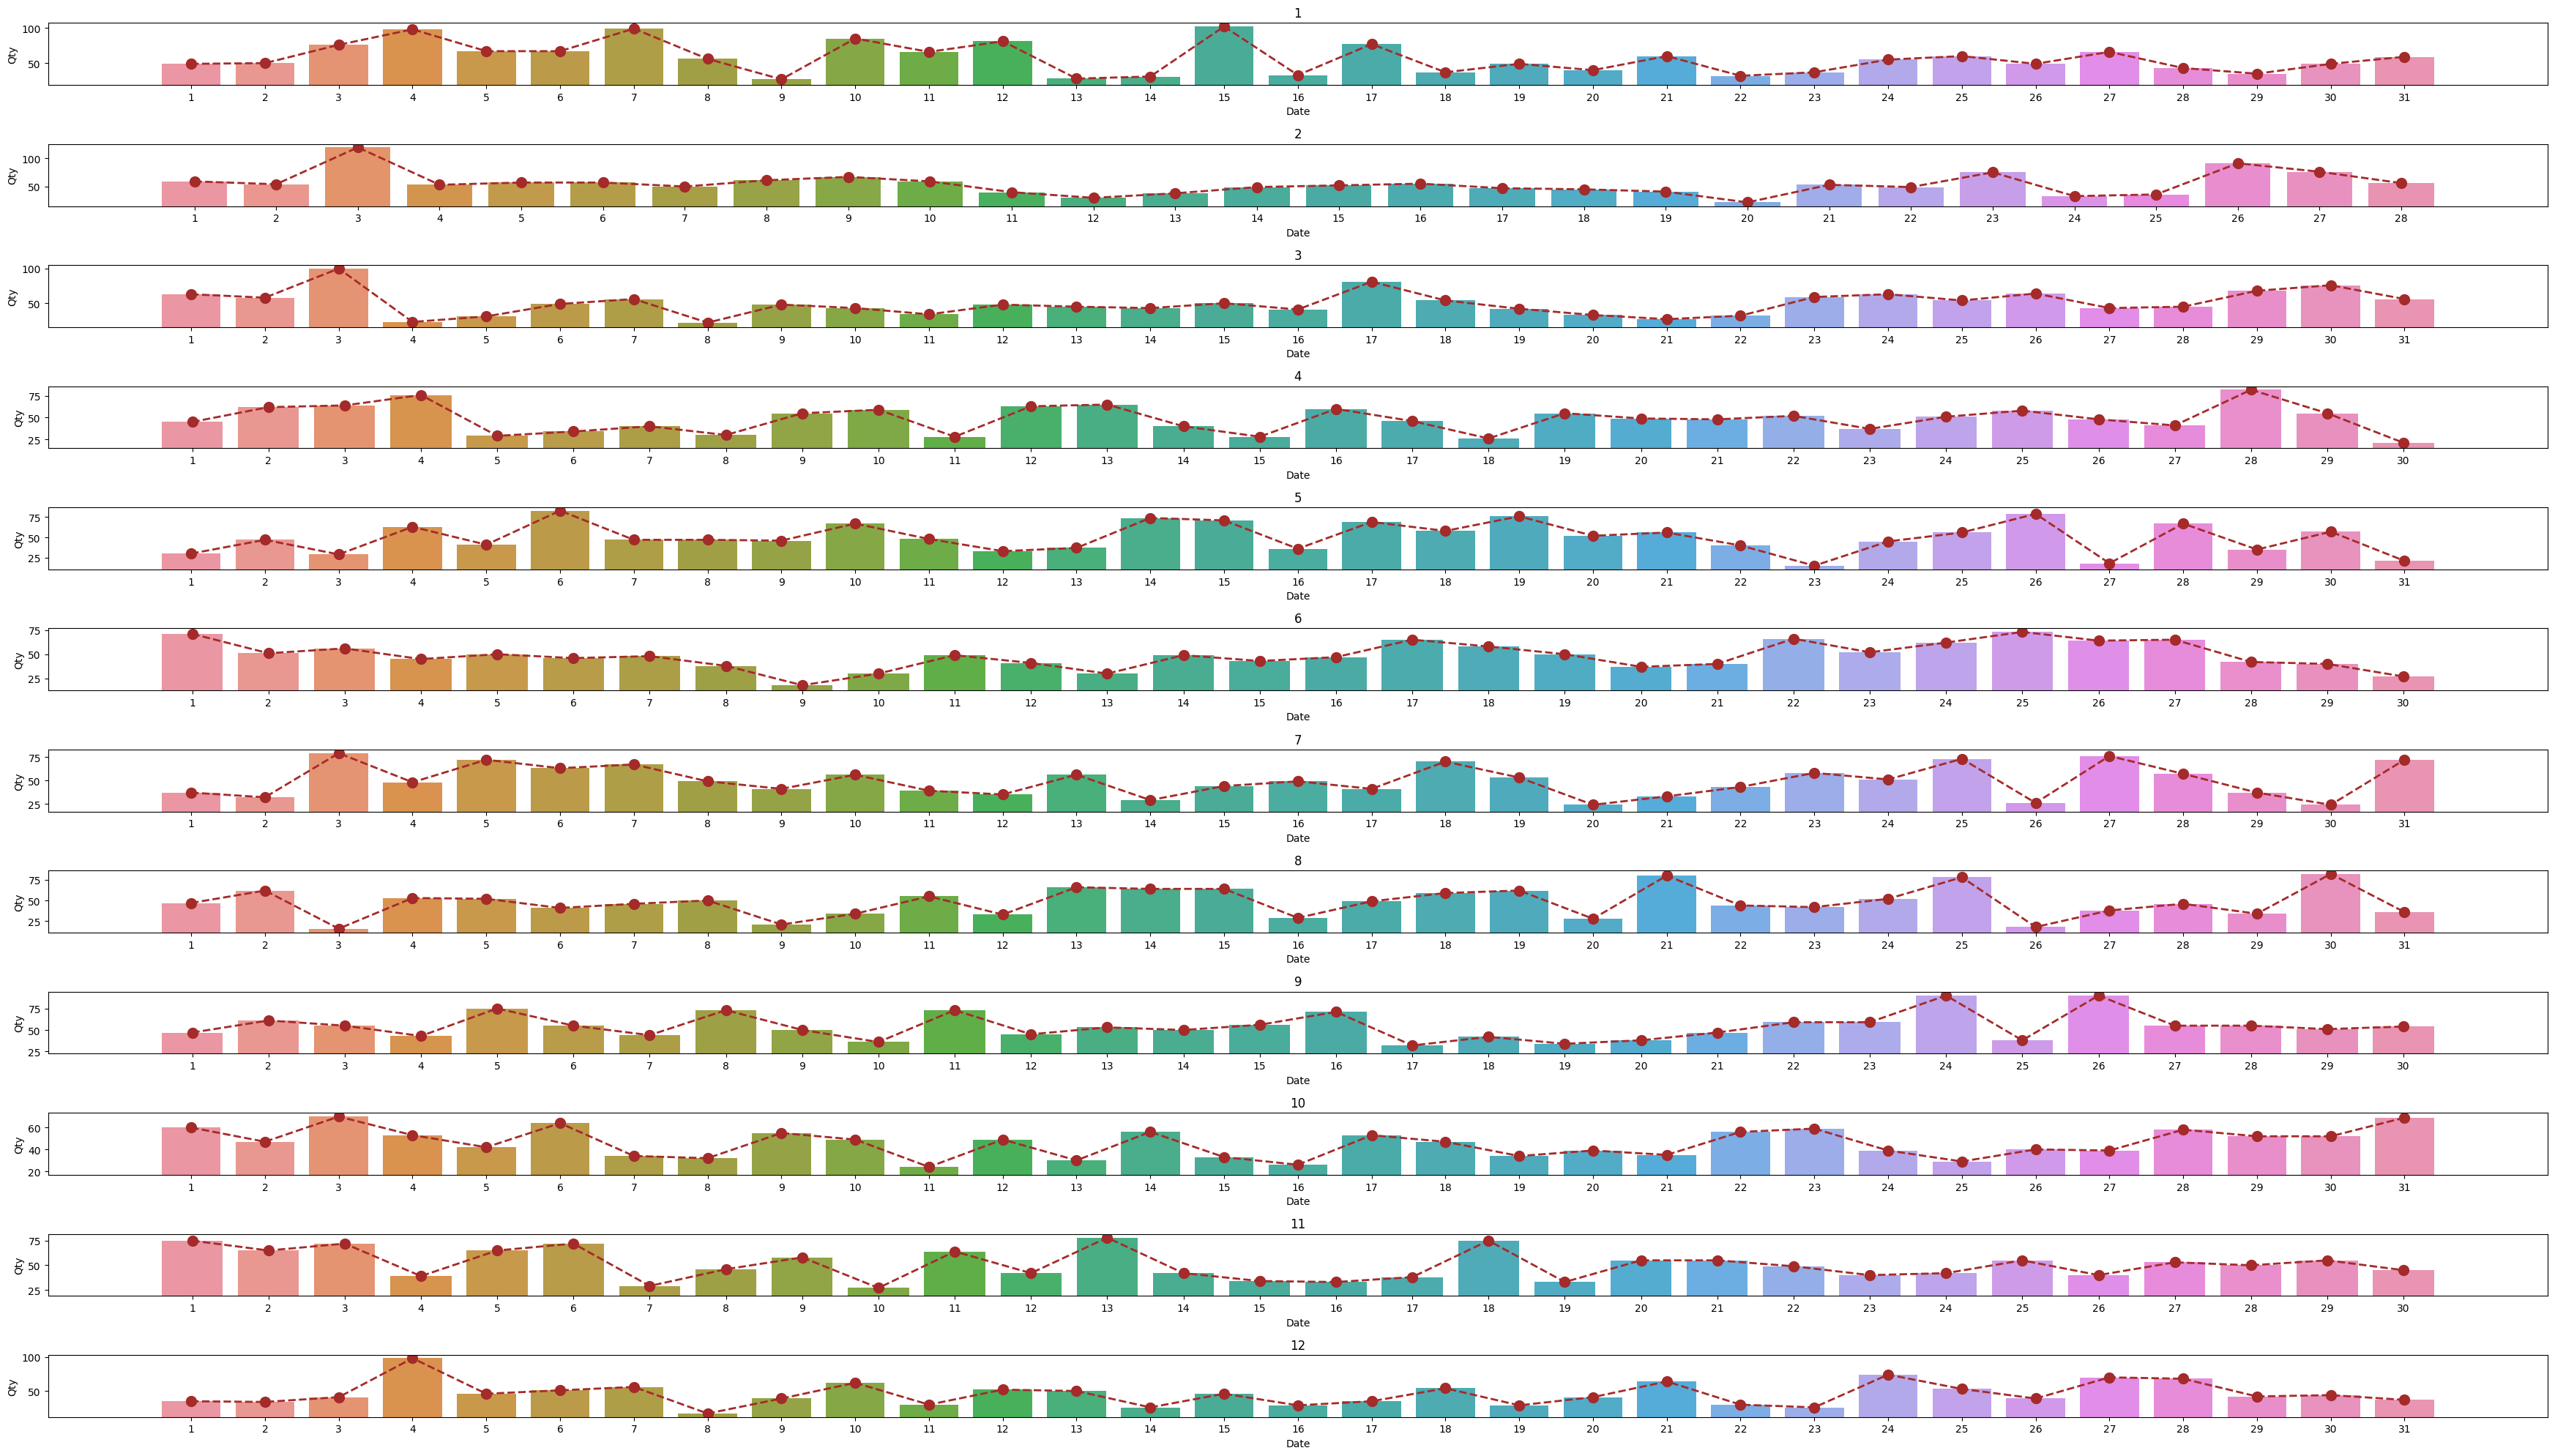

In [ ]:
fig, ax = plt.subplots(12, 1, figsize = (35, 20))
ax = ax.flatten()
for i, (combination, df) in enumerate(transaction.groupby(['Bulan'])):
    data = df.groupby(df.Date.dt.day)['Qty'].sum().reset_index()
    sns.barplot(data = data, x = 'Date', y = 'Qty', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.Qty,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    lims = ax[i].get_ylim()
    ax[i].set_ylim(data.Qty.min()*0.7, lims[1])
    ax[i].set_title(combination)
plt.tight_layout()

# Modeling


---



In [86]:
train_data = all_data[:272]
test_data = all_data[272:]

In [87]:
print(train_data.describe())
print(test_data.describe())

count    272.000000
mean      51.003676
std       17.213977
min       15.000000
25%       39.750000
50%       49.000000
75%       61.000000
max      119.000000
Name: Qty, dtype: float64
count    93.000000
mean     47.559140
std      14.907295
min      17.000000
25%      35.000000
50%      46.000000
75%      56.000000
max      98.000000
Name: Qty, dtype: float64


Mean dan standard deviasi dari train dan test sudah serupa

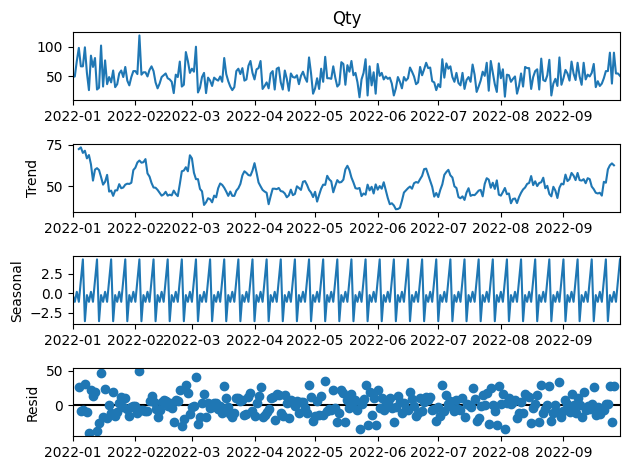

In [18]:
dec = seasonal_decompose(train_data)
dec.plot()
plt.show()

Terdapat seasonalitas setiap satu minggu dan trend cenderung datar

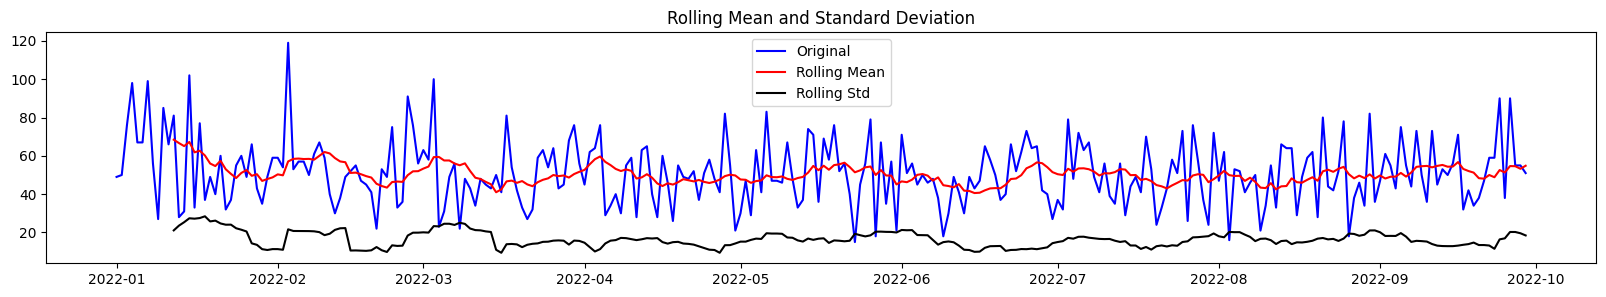

Results of Dickey Fuller Test
1. ADF :  -16.4603572159785
2. P-Value :  2.3332937828696704e-29
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 271
5. Critical Values :
	 1% :  -3.4547128138328875
	 5% :  -2.8722649771800155
	 10% :  -2.5724850011573914


In [19]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,3))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    dftest = adfuller(timeseries, autolag='AIC')

    print("Results of Dickey Fuller Test")
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
      print("\t",key, ": ", val)

test_stationarity(train_data)

Dikarenakan p-value < 0.05, maka kita dapat menolak $H_0$ dan menyatakan bahwa data stasioner. Rolling mean dan rolling standard deviasi juga menunjukkan tidak terdapat peningkatan.

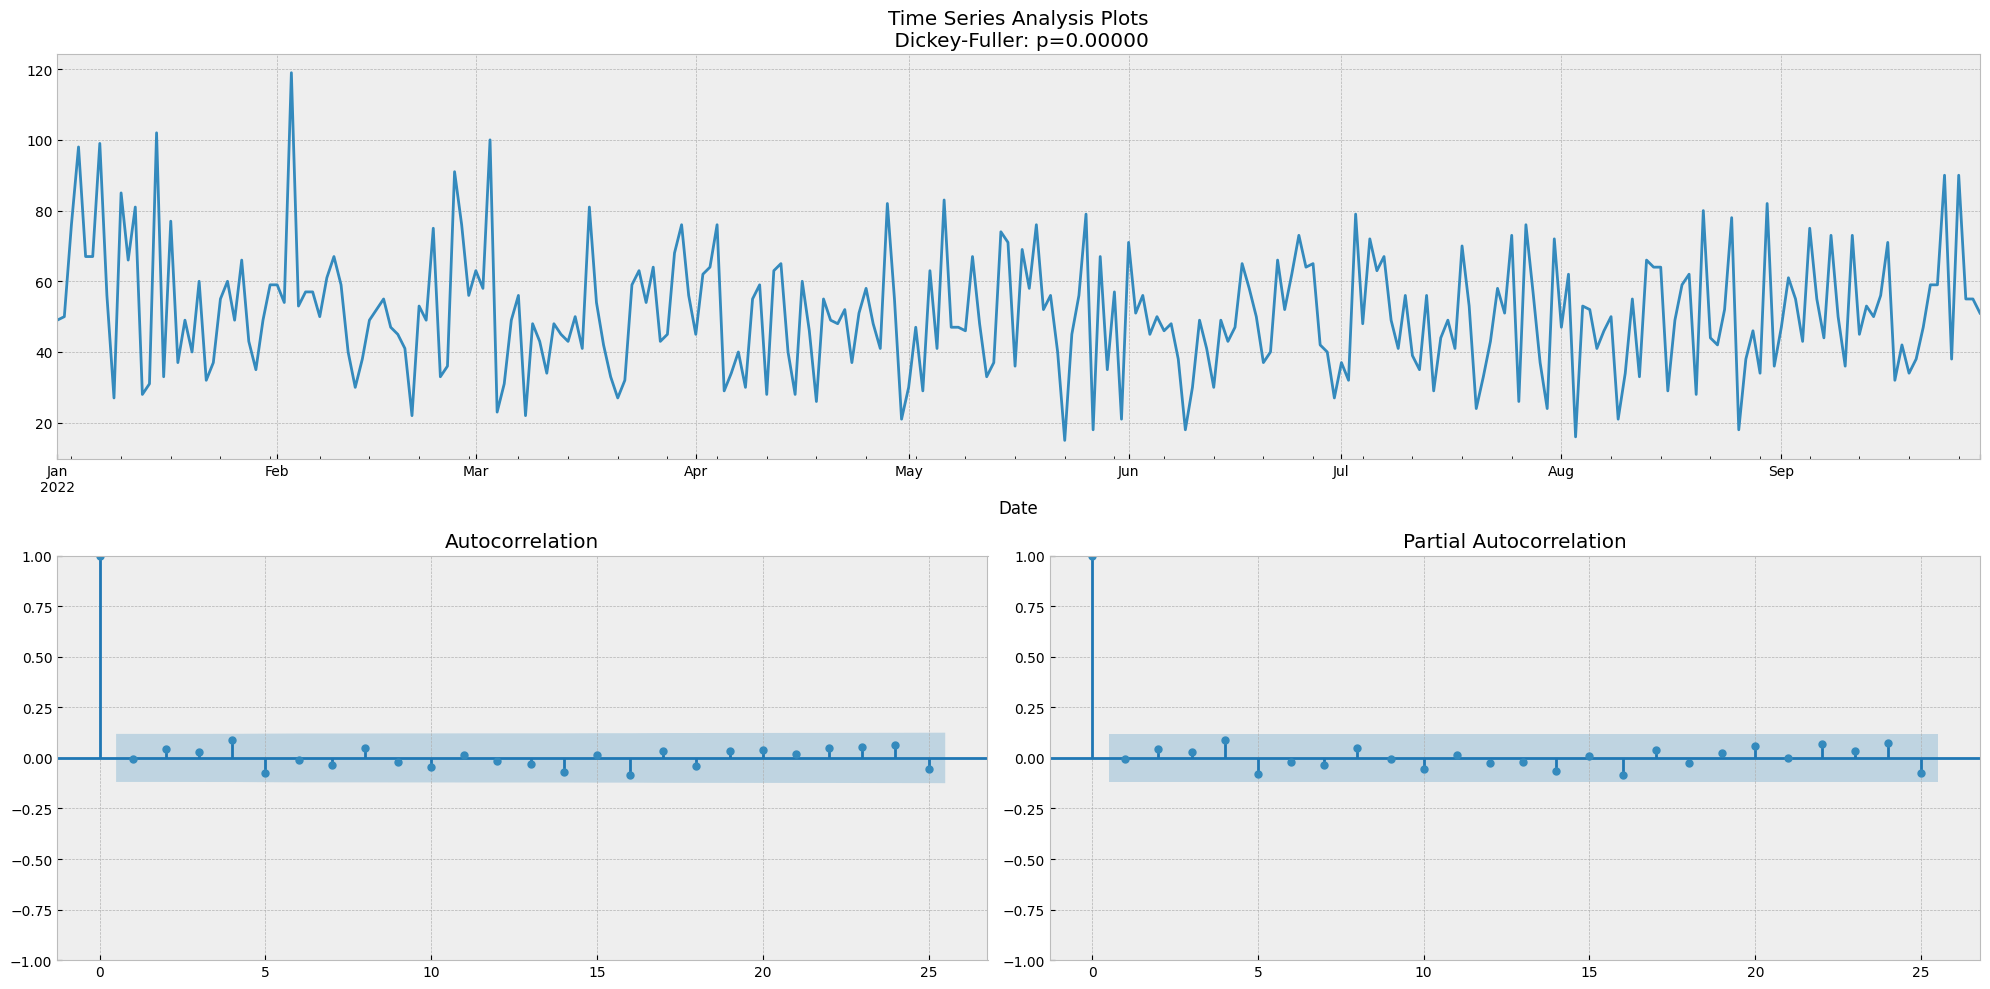

In [20]:
def tsplot(y, lags=None, figsize=(20,10), style='bmh'):
    import statsmodels.tsa.api as smt
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(train_data)

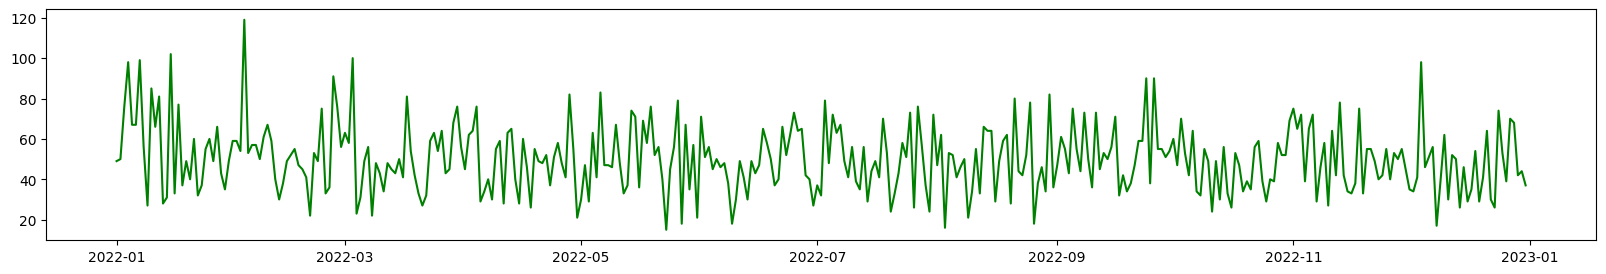

In [21]:
plt.figure(figsize=(20,3))
plt.plot(all_data, color = "green")

In [22]:
def plot_graph(pred, actual):
    plt.figure(figsize=(20,2))
    plt.plot(pred, color = "red")
    plt.plot(actual, color = "green")
    plt.legend(["Prediction", "Actual"])
    plt.title("Predicted vs True Value")
    plt.xlabel("Record number")
    plt.ylabel("target")
    plt.show()

# ARIMA dan SARIMAX


---



In [23]:
stepwise_model = auto_arima(train_data,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2329.418, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2322.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2324.970, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2324.970, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2942.095, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2326.973, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.674 seconds
2322.9733220633584


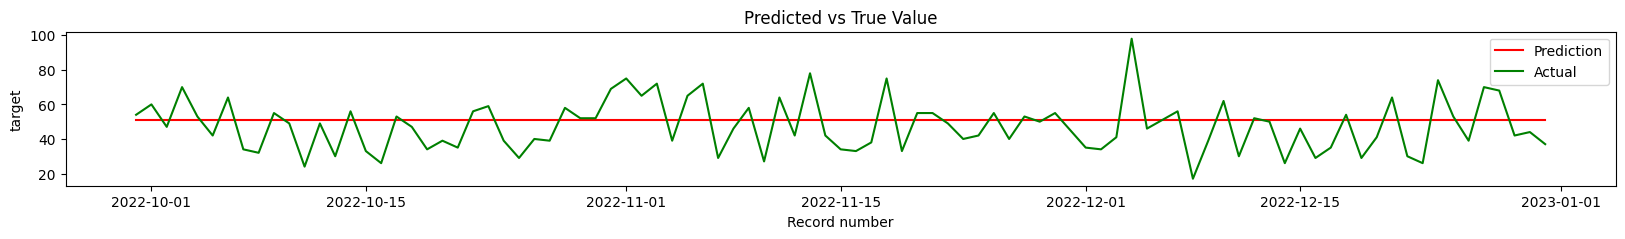

In [24]:
plot_graph(stepwise_model.predict(len(test_data)), test_data)

Model Auto ARIMA mengasilkan parameter (0,0,0) yang berarti prediksi merupakan konstan

Gunakan SARIMAX untuk menangkap seasonalitas pada data beserta dengan faktor external

In [25]:
external = pd.DataFrame(all_data)
external.drop('Qty', axis=1, inplace=True)

In [26]:
external[['Hari', 'Bulan']] = transaction.groupby('Date')[['Hari', 'Bulan']].mean().astype(int)
external.astype('category')

Hari Bulan
Date                 
2022-01-01    1     1
2022-01-02    2     1
2022-01-03    3     1
2022-01-04    4     1
2022-01-05    5     1
...         ...   ...
2022-12-27   27    12
2022-12-28   28    12
2022-12-29   29    12
2022-12-30   30    12
2022-12-31   31    12

[365 rows x 2 columns]

In [27]:
for hari in holidays.Indonesia(years = 2022).items():
    print(hari)

(datetime.date(2022, 1, 1), 'Tahun Baru Masehi')
(datetime.date(2022, 2, 1), 'Tahun Baru Imlek')
(datetime.date(2022, 3, 3), 'Hari Suci Nyepi')
(datetime.date(2022, 5, 2), 'Hari Raya Idul Fitri')
(datetime.date(2022, 5, 3), 'Hari kedua dari Hari Raya Idul Fitri')
(datetime.date(2022, 7, 10), 'Hari Raya Idul Adha')
(datetime.date(2022, 7, 30), 'Tahun Baru Islam')
(datetime.date(2022, 10, 8), 'Maulid Nabi Muhammad')
(datetime.date(2022, 2, 28), "Isra' Mi'raj Nabi Muhammad")
(datetime.date(2022, 4, 15), 'Wafat Yesus Kristus')
(datetime.date(2022, 5, 16), 'Hari Raya Waisak')
(datetime.date(2022, 5, 1), 'Hari Buruh Internasional')
(datetime.date(2022, 5, 26), 'Kenaikan Yesus Kristus')
(datetime.date(2022, 6, 1), 'Hari Lahir Pancasila')
(datetime.date(2022, 8, 17), 'Hari Kemerdekaan Republik Indonesia')
(datetime.date(2022, 12, 25), 'Hari Raya Natal')


In [28]:
libur = pd.to_datetime(['2022-1-1', '2022-2-1', '2022-3-3', '2022-5-2','2022-5-3','2022-7-10','2022-7-30', '2022-10-8', '2022-2-28', '2022-4-15', '2022-5-16', '2022-5-1', '2022-5-26', '2022-6-1', '2022-8-17', '2022-12-25'])
external['Libur'] = 0
for hari in libur:
  external.loc[hari]['Libur'] = 1

In [29]:
for i in range(1,365,7):
  temp = external.iloc[i-1]
  external.loc[(external['Hari'] == temp['Hari']) & (external['Bulan'] == temp['Bulan']), 'Libur'] = 1
  temp = external.iloc[i]
  external.loc[(external['Hari'] == temp['Hari']) & (external['Bulan'] == temp['Bulan']), 'Libur'] = 1

In [30]:
external

Hari  Bulan  Libur
Date                          
2022-01-01     1      1      1
2022-01-02     2      1      1
2022-01-03     3      1      0
2022-01-04     4      1      0
2022-01-05     5      1      0
...          ...    ...    ...
2022-12-27    27     12      0
2022-12-28    28     12      0
2022-12-29    29     12      0
2022-12-30    30     12      0
2022-12-31    31     12      0

[365 rows x 3 columns]

In [65]:
model=SARIMAX(endog=train_data, initialization='approximate_diffuse', order = (2,1,0), seasonal_order = (1, 2, 1, 12), trens='t')
mdl = model.fit(disp=0)
predictions = round(mdl.forecast(len(test_data)))
predictions = pd.Series(predictions, index=test_data.index)
print(predictions)
print(mse(predictions, test_data, squared=False))

Date
2022-09-30    45.0
2022-10-01    36.0
2022-10-02    51.0
2022-10-03    46.0
2022-10-04    51.0
              ... 
2022-12-27    41.0
2022-12-28    54.0
2022-12-29    53.0
2022-12-30    18.0
2022-12-31    63.0
Name: predicted_mean, Length: 93, dtype: float64
19.76610545178748


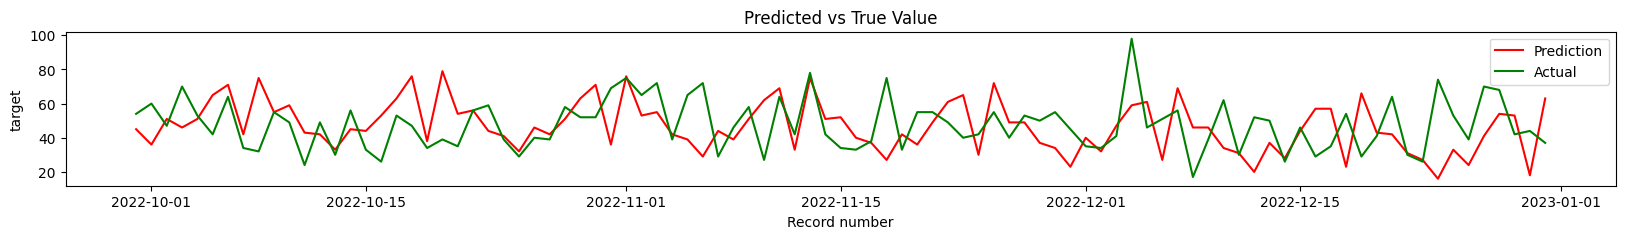

In [66]:
plot_graph(predictions, test_data)

In [63]:
model=SARIMAX(endog=train_data, exog= np.array(external['Libur'][:272]), initialization='approximate_diffuse', order = (2,1,0), seasonal_order = (1, 2, 1, 12), trens='t')
mdl = model.fit(disp=0)
predictions = round(mdl.forecast(len(test_data), exog = np.array(external['Libur'][272:])))
predictions = pd.Series(predictions, index=test_data.index)
print(predictions)
print(mse(predictions, test_data, squared=False))

Date
2022-09-30    45.0
2022-10-01    35.0
2022-10-02    50.0
2022-10-03    46.0
2022-10-04    51.0
              ... 
2022-12-27    39.0
2022-12-28    52.0
2022-12-29    51.0
2022-12-30    17.0
2022-12-31    61.0
Name: predicted_mean, Length: 93, dtype: float64
20.031695315282256


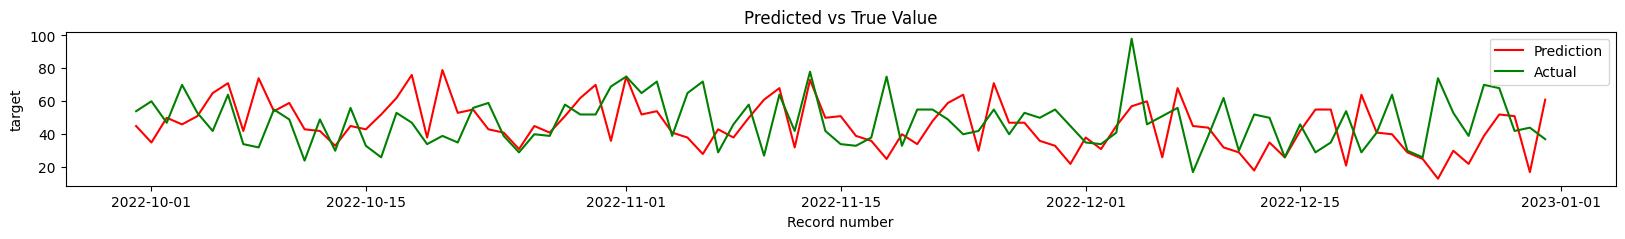

In [64]:
plot_graph(predictions, test_data)

Terlihat model tersebut sudah dapat menangkap pola dari data, tetapi d = 1 dan D = 2, dimana sebenarnya data tidak memerlukan parameter d dan D (Integrated) dikarenakan data tidak perlu dilakukan differencing (sudah stasioner)

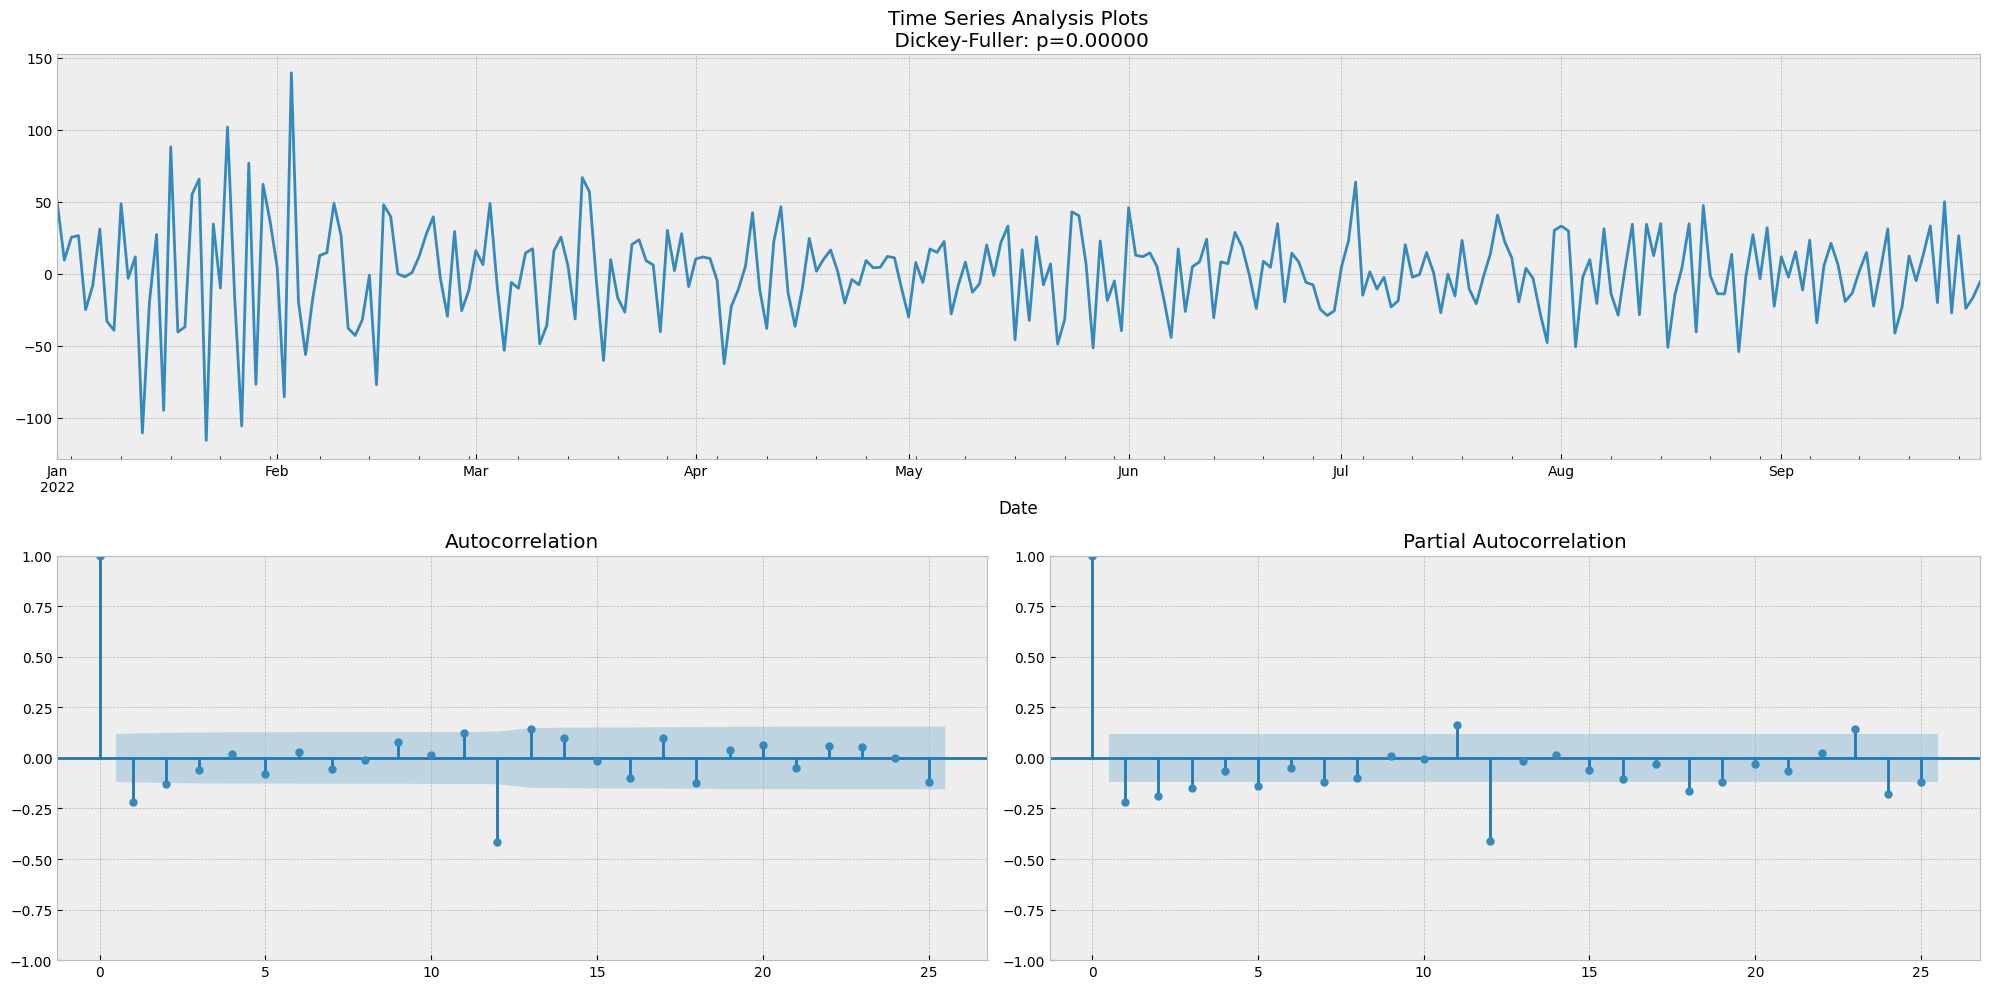

In [35]:
tsplot(mdl.resid)

In [36]:
stepwise_model = auto_arima(train_data, exog = np.array(external['Libur'][:272]), start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=1, seasonal=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=2329.485, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2322.973, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2326.605, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2326.541, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2942.095, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=2324.606, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=2324.541, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=2326.513, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2324.970, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=2324.970, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=2326.973, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 1.970 seconds
2322.9733220633584


Lakukan pencarian parameter terbaik dengan d = D = 0, dan perhitungan berdasarkan RMSE dan Standard Deviasi yang mendekati data aslinya

In [43]:
def search_param(external = None):
    p = q = range(4)
    pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]
    p = q = range(3)
    pdqs = [(x[0], 0, x[1], 7) for x in list(itertools.product(p, q))]
    for param in itertools.product(pdq, pdqs):
        model=SARIMAX(endog=train_data, exog = external[:272], order = param[0], seasonal_order = param[1])
        try:
            mdl = model.fit()
            predictions = mdl.forecast(len(test_data), exog = external[272:])
            print("Param :", param, "RMSE :", mse(predictions, test_data, squared=False), "Std :", stat.stdev(predictions))
        except:
            print("Param :", param, "LU Decompotition Error")

In [38]:
search_param()

Param : ((0, 0, 0), (0, 0, 0, 7)) RMSE : 49.81676100891501 Std : 0.0
Param : ((0, 0, 0), (0, 0, 1, 7)) RMSE : 48.12605129091328 Std : 8.206014535274837
Param : ((0, 0, 0), (0, 0, 2, 7)) RMSE : 46.80116818641849 Std : 14.484086161501804
Param : ((0, 0, 0), (1, 0, 0, 7)) RMSE : 25.724503577818098 Std : 16.138428428809885
Param : ((0, 0, 0), (1, 0, 1, 7)) RMSE : 15.408464815150285 Std : 2.092365812682644
Param : ((0, 0, 0), (1, 0, 2, 7)) RMSE : 15.491433182742057 Std : 2.571285979657917
Param : ((0, 0, 0), (2, 0, 0, 7)) RMSE : 18.941452842658524 Std : 10.233100563066225
Param : ((0, 0, 0), (2, 0, 1, 7)) RMSE : 15.452200304233251 Std : 2.356613067396905
Param : ((0, 0, 0), (2, 0, 2, 7)) RMSE : 15.586648105539716 Std : 2.429124735618118
Param : ((0, 0, 1), (0, 0, 0, 7)) RMSE : 49.713950137037926 Std : 1.0036714948100247
Param : ((0, 0, 1), (0, 0, 1, 7)) RMSE : 48.20461769677132 Std : 6.737705580675137
Param : ((0, 0, 1), (0, 0, 2, 7)) RMSE : 46.93451139825923 Std : 12.02492644603945
Param :

In [44]:
search_param(external = external['Libur'])

Param : ((0, 0, 0), (0, 0, 0, 7)) RMSE : 41.48193585935662 Std : 22.88917664505259
Param : ((0, 0, 0), (0, 0, 1, 7)) RMSE : 40.60597809274964 Std : 18.87042425652799
Param : ((0, 0, 0), (0, 0, 2, 7)) RMSE : 40.414099169212065 Std : 18.184478351321786
Param : ((0, 0, 0), (1, 0, 0, 7)) RMSE : 25.719531187447924 Std : 16.074636580935437
Param : ((0, 0, 0), (1, 0, 1, 7)) RMSE : 15.318046283035907 Std : 2.2003615581846163
Param : ((0, 0, 0), (1, 0, 2, 7)) RMSE : 15.436167305519405 Std : 2.7231763614070266
Param : ((0, 0, 0), (2, 0, 0, 7)) RMSE : 18.644074451492383 Std : 10.11344408837083
Param : ((0, 0, 0), (2, 0, 1, 7)) RMSE : 15.385248263395553 Std : 2.5053496069508316
Param : ((0, 0, 0), (2, 0, 2, 7)) RMSE : 15.548833836413312 Std : 2.3122809919919245
Param : ((0, 0, 1), (0, 0, 0, 7)) RMSE : 42.555670979984406 Std : 14.934052814612244
Param : ((0, 0, 1), (0, 0, 1, 7)) RMSE : 41.67654477924955 Std : 14.560652489849788
Param : ((0, 0, 1), (0, 0, 2, 7)) RMSE : 41.20527346973042 Std : 15.114

2022-09-30    54.0
2022-10-01    67.0
2022-10-02    55.0
2022-10-03    59.0
2022-10-04    53.0
              ... 
2022-12-27    49.0
2022-12-28    45.0
2022-12-29    49.0
2022-12-30    45.0
2022-12-31    49.0
Freq: D, Name: predicted_mean, Length: 93, dtype: float64
15.055810152723058


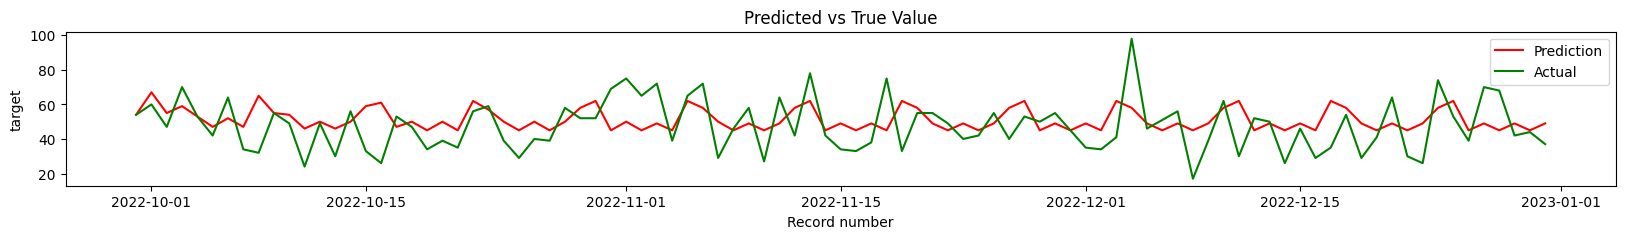

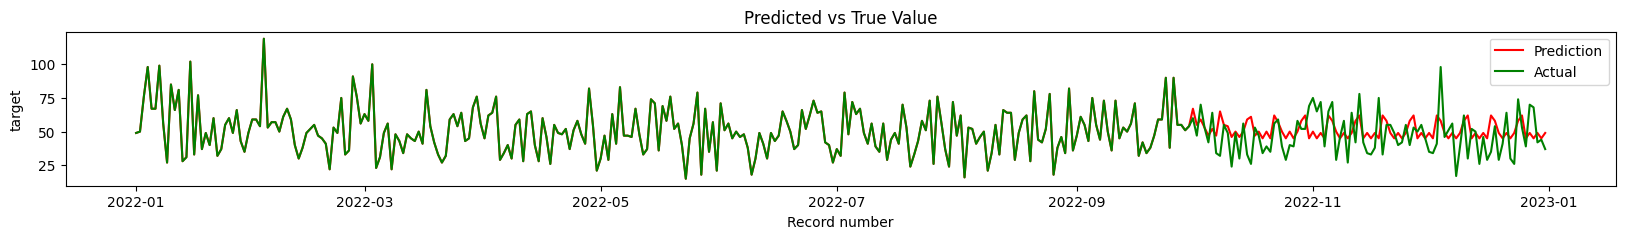

In [59]:
model=SARIMAX(endog=train_data, initialization='stationary', exog = np.array(external['Libur'][:272]), order = (2, 0, 2), seasonal_order = (1, 0, 0, 7))
mdl = model.fit()
predictions = round(mdl.forecast(len(test_data), exog = np.array(external['Libur'][272:])))
print(predictions)
print(mse(predictions, test_data, squared=False))
plot_graph(predictions, test_data)
plot_graph(train_data.append(predictions), all_data)

2022-09-30    57.0
2022-10-01    59.0
2022-10-02    53.0
2022-10-03    45.0
2022-10-04    40.0
              ... 
2022-12-27    32.0
2022-12-28    35.0
2022-12-29    31.0
2022-12-30    30.0
2022-12-31    31.0
Freq: D, Name: predicted_mean, Length: 93, dtype: float64
17.70608303222613


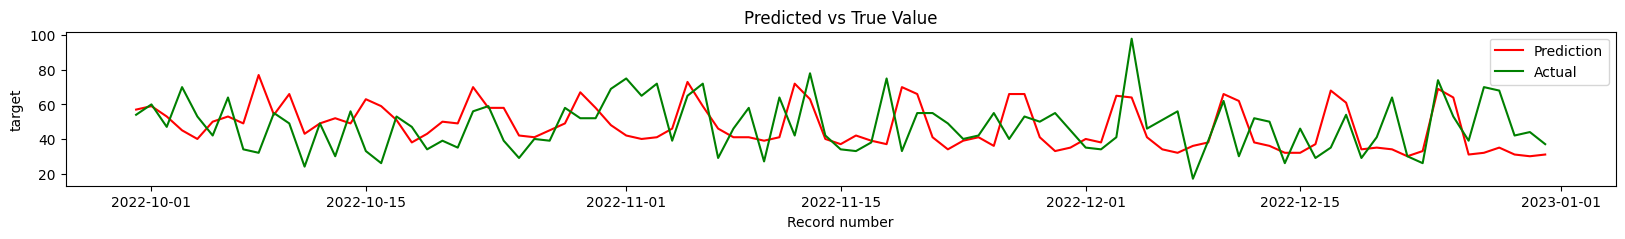

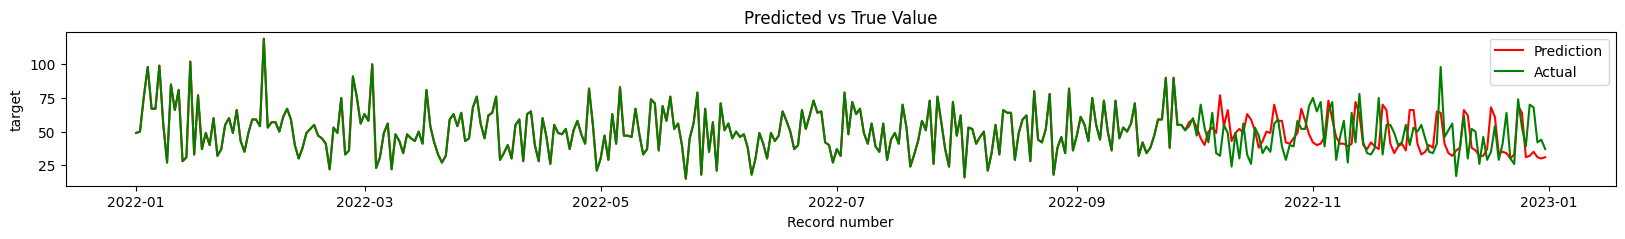

In [62]:
model=SARIMAX(endog=train_data, initialization='stationary', exog = np.array(external['Libur'][:272]), order = (3, 0, 3), seasonal_order = (2, 0, 0, 7))
mdl = model.fit()
predictions = round(mdl.forecast(len(test_data), exog = np.array(external['Libur'][272:])))
print(predictions)
print(mse(predictions, test_data, squared=False))
plot_graph(predictions, test_data)
plot_graph(train_data.append(predictions), all_data)

Beberapa model dengan seasonalitas dan external data tersebut berhasil memprediksi kapan terjadinya peningkatan penjualan, sehingga barang dapat dipersiapkan terlebih dahulu pada hari-hari tertentu

# Clustering


---



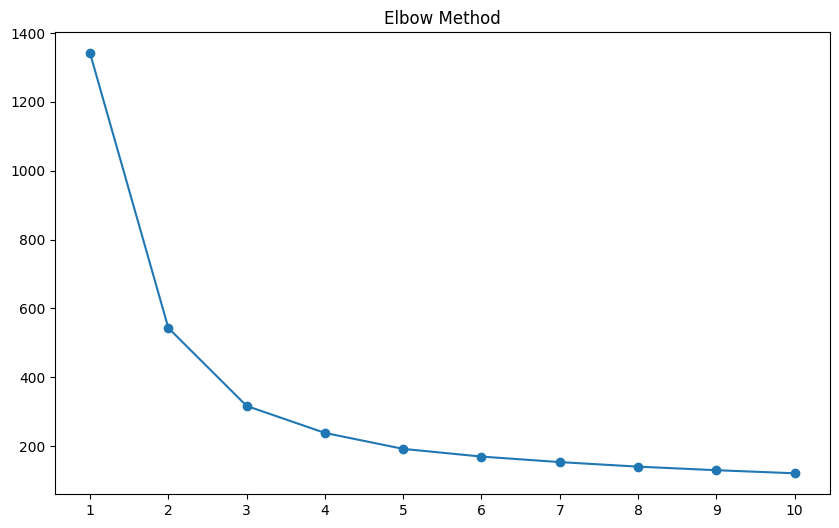

In [94]:
sc = StandardScaler()
scaled_cluster = sc.fit_transform(cluster_data)

inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.xticks(list(range(1,11)))
plt.plot(range(1,11),inertia,marker='o')
plt.title('Elbow Method')
plt.show()

Didapat dari elbow method, bahwa n cluster paling optimal adalah 3

In [96]:
model = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
model.fit(scaled_cluster)
labels3 = model.labels_

In [97]:
cluster_data['Label'] =  labels3
trace1 = go.Scatter3d(
    x= cluster_data['TransactionID'],
    y= cluster_data['Qty'],
    z= cluster_data['TotalAmount'],
    mode='markers',
     marker=dict(
        color = cluster_data['Label'],
        size= 20,
        line=dict(
            color= cluster_data['Label'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Transaction'),
            yaxis = dict(title  = 'Quantity'),
            zaxis = dict(title  = 'Total Amount')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

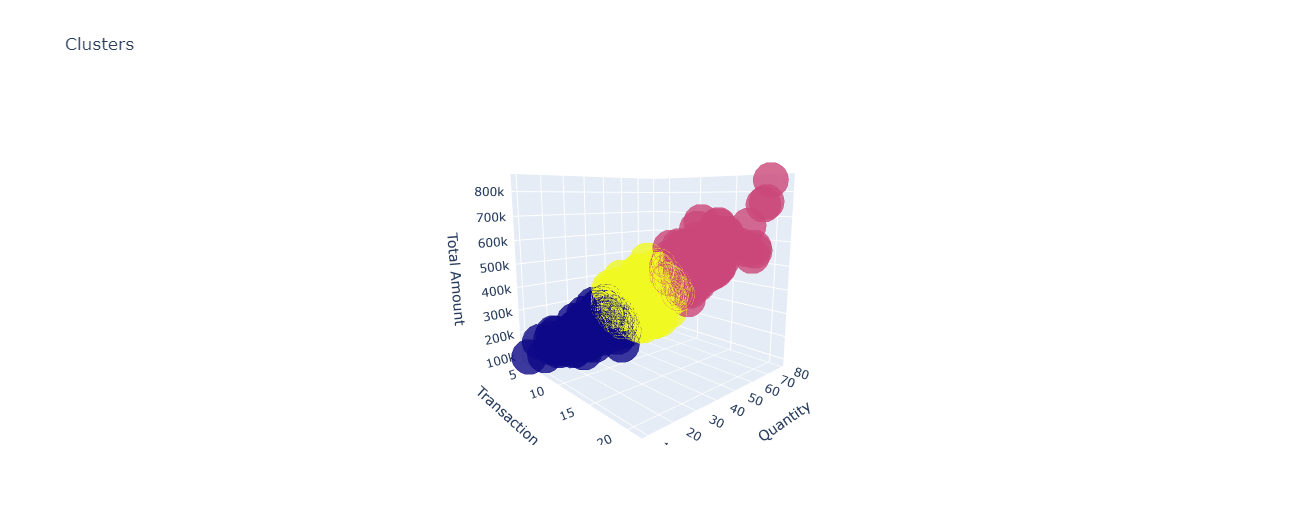

In [102]:
Image(filename='3D.png')

<Figure size 400x400 with 0 Axes>

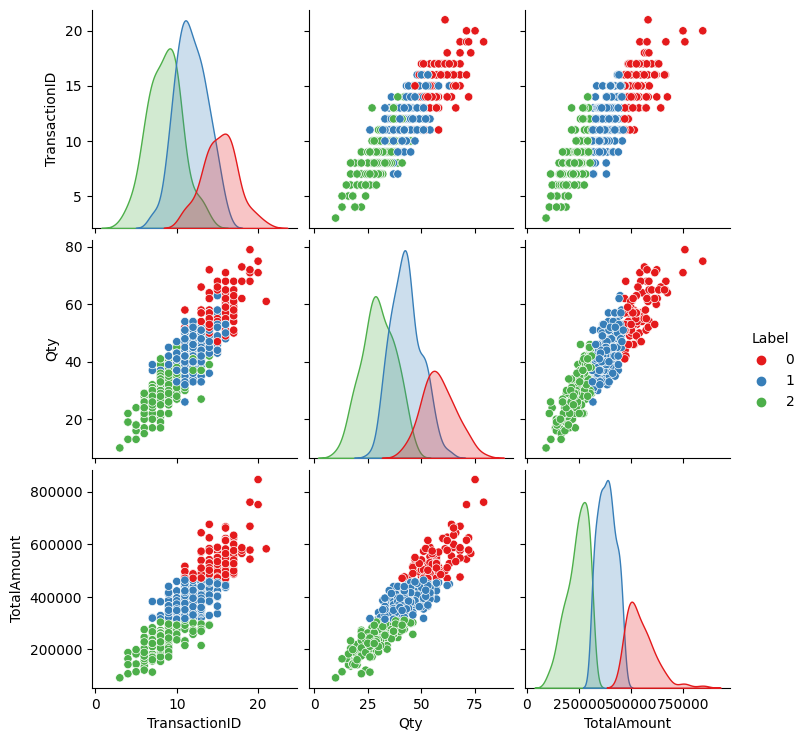

In [85]:
plt.figure(figsize=(4,4))
sns.pairplot(data=cluster_data, hue='Label', palette='Set1')
plt.show()

Dilihat dari plot, customer dapat dipisahkan menjadi 3 cluster


*   Cluster 0 yang sudah sering bertransaksi. Berikan bonus loyalti, seperti merchandise atau diskon. Dengarkan saran dan kritik dari mereka.
*   Cluster 1 yang merupakan pengguna yang sudah lumayan sering bertransaksi. Berikan mereka penawaran akan bonus loyalti supaya semakin tertarik.
*   Cluster 2 yang merupakan pengguna baru. Berikan banyak promosi terkait produk-produk yang dijual.

